In [ ]:
# # Colab setup

# try:
#     from dlroms import *
# except:
#     !pip install git+https://github.com/NicolaRFranco/dlroms.git
#     from dlroms import *

In [ ]:
# Import libraries

import numpy as np
import os
import torch
import matplotlib.pyplot as plt

from dolfin import *
from dlroms import *
from dlroms.dnns import *

from IPython.display import clear_output as clc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Domain and mesh definition

mesh = fe.unitsquaremesh(100, 100)
V = fe.space(mesh, 'CG', 1)
Nh = V.dim()

clc()

In [ ]:
# Load snapshots

N_snapshots = 4800

path_train = os.path.join('snapshots', 'snapshots_train_H_' + str(N_snapshots) + '.npz')
data_train = np.load(path_train)

N_train = data_train['mu'].shape[0]
mu_train, u_train = data_train['mu'].astype(np.float32), data_train['u'].astype(np.float32)
mu_train, u_train = torch.tensor(mu_train).to(device), torch.tensor(u_train).to(device)

path_test = os.path.join('snapshots', 'snapshots_test.npz')
data_test = np.load(path_test)

N_test = data_test['mu'].shape[0]
mu_test, u_test = data_test['mu'].astype(np.float32), data_test['u'].astype(np.float32)
mu_test, u_test = torch.tensor(mu_test).to(device), torch.tensor(u_test).to(device)

In [ ]:
# Traning architecture

m = 16
k = 4

psi_prime = Dense(Nh, 4, activation=None)

psi = Dense(4, 100 * m) + \
		Reshape(4 * m, 5, 5) + \
		Deconv2D(11, (4 * m, 2 * m), 2) + \
		Deconv2D(10, (2 * m, m), 2) + \
		Deconv2D(11, (m, 1), 2, activation=None) + \
		Reshape(-1)

phi = Dense(4, 50 * k) + \
		Dense(50 * k, 50 * k) + \
		Dense(50 * k, 4, activation=None)

print("Trainable parameters:")
print("  Encoder:", psi_prime.dof())
print("  Decoder:", psi.dof())
print("  Dense NN:", phi.dof())

# psi.dims()

In [ ]:
# Train the autoencoder (nonlinear dimensionality reduction)

autoencoder = DFNN(psi_prime, psi) # encoder + decoder
autoencoder.He()

if torch.cuda.is_available():
	autoencoder.cuda()

autoencoder.train(u_train, u_train, ntrain=N_train, epochs=200, loss=mre(euclidean), verbose=True)

		Train		Test
Epoch 200:	3.29e-02	nan.

>> ETA: 15.02s.

Training complete. Elapsed time: 50 minutes 4.92 seconds.


In [ ]:
# Use the trained encoder to generate the reduced order version of the dataset

psi_prime.eval()

with torch.no_grad():
	u_train_ro = psi_prime(u_train)

In [ ]:
# Use the reduced dataset to train the dense NN mapping the parameters to the reduced order solution

dense = DFNN(phi)
dense.He()

if torch.cuda.is_available():
	dense.cuda()

dense.train(mu_train, u_train_ro, ntrain=N_train, epochs=200, loss=mse(euclidean), verbose=True)

		Train		Test
Epoch 200:	1.66e-01	nan.

>> ETA: 0.27s.

Training complete. Elapsed time: 53.57 seconds.


In [ ]:
# Use the dense NN to predict the reduced order solution and the decoder to restore the full order solution

phi.eval()
psi.eval()

with torch.no_grad():
	u_train_pred = psi(phi(mu_train))

error_train = mre(euclidean)(u_train, u_train_pred)
print(f"Relative training error: {100 * torch.mean(error_train):.2f}%")

In [ ]:
# Apply the model to the test set

with torch.no_grad():
  u_test_pred = psi(phi(mu_test))

error_test = torch.norm(u_test - u_test_pred, dim=1) / torch.norm(u_test, dim=1)
print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))

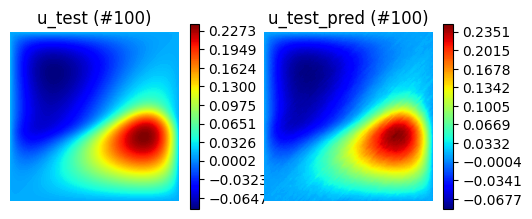

In [ ]:
# Plot some results

idx = 100

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
fe.plot(u_test[idx, :], V, colorbar=True)
plt.title('u_test (#' + str(idx) + ')')
plt.subplot(1, 2, 2)
fe.plot(u_test_pred[idx, :], V, colorbar=True)
plt.title('u_test_pred (#' + str(idx) + ')')
plt.show()

In [ ]:
# Save encoder, decoder, and dense NN

if not os.path.exists('checkpoints'):
	os.makedirs('checkpoints')

torch.save(psi_prime.state_dict(), os.path.join('checkpoints', 'psi_prime_' + str(N_snapshots) + '.pth'))
torch.save(psi.state_dict(), os.path.join('checkpoints', 'psi_' + str(N_snapshots) + '.pth'))
torch.save(phi.state_dict(), os.path.join('checkpoints', 'phi_' + str(N_snapshots) + '.pth'))